# Imports

Run this cell to import the following libraries (they will be necessary for what follows).

In [ ]:
# Install cuda 1.21 if needed, so we can use our GPU
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [1]:
import urllib.request
import tarfile
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Subset
import torch.nn as nn
from torch import optim
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import clear_output
import time
import torch.nn.functional as fun


# Overview


In this assignment you will use a convolutional neural network to make predictions concerning images in the CIFAR10 dataset. CIFAR10 is a dataset of 60,000 RGB images where each channel is 32x32 pixels. Typically, 50,000 of these images are used for training and 10,000 are used for testing. It is strongly recommended you develop your code and this notebook on colab.


### Some general points on notation

Typically we use
- $[n] = \{ 1,2,3...n\}$, $[m,n] = \{m, m+1... n\}$ to denote sets frequently used for indices,
- $\mathbb{1}(E)$ is the indicator function for event E: for example, $\mathbb{1}(a>b) = 1$ if $a>b$ and is $0$ otherwise.
- $L$ as the scalar valued loss of the network on a batch,
- $x$ as the tensor of input features,
- $y$ as the tensor of labels,
- $a$ as the output tensor from a layer,
- $z$ as the input tensor to a layer.
- $\frac{\partial L}{\partial a}$ is a tensor with the same shape as $a$ but with each element being the partial derivative of $L$ with respect to the corresponding element in $a$. For example, if $a \in\mathbb{R}^{N,M,O}$ then $\frac{\partial L}{\partial a} \in \mathbb{R}^{N,M,O}$ and $\left[\frac{\partial L}{\partial a} \right]_{i,j,k} = \frac{\partial L}{\partial a_{i,j,k}}$.
- For a given layer with input tensor $z$ and output tensor $a$, we use $\delta = \frac{\partial L}{\partial a}$ to denote the error signal tensor propagated during the backward pass from the layer above, and $\delta_{new} = \frac{\partial L}{\partial z}$ to denote the error signal tensor propagated from the current layer to the one below.


### High level hints and tips

1. Everytime you write a function or class you need to think of ways you can test it to make sure it is working as it should be.
 - Always check that the shape of the tensors outputted by a layer or function make sense / agree with what they should be.
 - Use small, simple trial cases to test your functions and class member functions (methods). These trial cases should be easy for you to check by hand in order to confirm your functions are behaving correctly.
 - When possible, consider checking that your function outputs are the same versus their equivalents in Pytorch! This is the only acceptable use of Pytorch during this assignment.

2. For each layer you will need to implement a backward method to backpropagate error signals. You will in every case have to derive the backpropagation rule and try to implement it efficiently. Suppose $L$ is some scalar valued loss, $a$ is, e.g., a three dimensional tensor which is the output of the forward function of a layer, and $z$ is also a three dimensional tensor which is the input to the aforementioned layer. Then
 - first, compute $\frac{\partial a_{i,j,k}}{ \partial z_{m,n,o}}$,
 - second, substitute this into the chain rule, $ \frac{\partial L}{\partial z_{m,n,o}} = \sum_{i,j,k}\frac{\partial L}{\partial a_{i,j,k}} \frac{ \partial a_{i,j,k}}{\partial z_{m,n,o}}$.
 - Third, look for patterns that allow you to represent $\frac{\partial L}{\partial z}$ succinctly.

3. Although you are awarded some points for the performance of your model, many of the marks in Part II come from demonstrating and communicating a clear approach to and awareness and understanding of how to improve the training and generalization of neural networks.

4. This coursework is designed to be challenging, you should not expect to answer every question perfectly. Don't stress if you struggle at times and also think carefully about diminishing returns: you have limited time given your other academic commitments, hard questions are worth fewer marks and also will likely take more time to solve!




# PART I
In this part of the coursework we build on the final lab and use Pytorch to develop a performant model for processing the CIFAR10 dataset.

# Q1. [25 marks] Build and train a CNN in Pytorch to process CIFAR10

### Overview

Building on the final lab, use Pytorch to define and train a model which achieves a high prediction accuracy on test data (not used during training to select parameters or hyperparameters). Feel free to use the code from your last lab to get you started. This question is worth 40 marks and you will receive marks for
 - your final model's performance / test score (test accuracy),
 - evidence you have attempted to improve performance using at least some combination of the techniques outlined below (or others). In short, I expect you to build on and adapt the code provided in lab 9.

Things you might want to try to improve training and test accuracy.
- Try different architectures and layers, see what happens if you include or don't include certain layers, identify computational bottlenecks and take steps to mitigate overfitting.
- When you import the data think about preprocessing techniques: for example, normalizing the data so that pixel values in each channel have mean zero and standard deviation one. If your model is not generalizing well then try data augmentation techniques such as cropping, blurring or rotation.
- Consider using k-fold cross validation to find good hyperparameters.
- Instead of using SGD experiment with other optimizers: for example, momentum, RMSprop or ADAM, compare the resulting error curves.

### Develop and train your model to perform well on CIFAR10

# Load data and CNN model

In [2]:
# Hyperparameters
batch_size = 512

# Normalization parameters for CIFAR-10 (standard)
# These are the per-channel means and stds computed over the CIFAR-10 dataset
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Transformations for the training data
transform_train = transforms.Compose([
 #   transforms.RandomCrop(32, padding=4),
 #   transforms.RandomHorizontalFlip(),
 #   transforms.RandomRotation(15),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
#    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])

# Transformations for the testing data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



# Load training and validation datasets
trainset = datasets.CIFAR10(root='./CIFAR10_data/', train=True, download=True, transform=transform_train)
#trainset_partial = Subset(trainset_full, list(range(3000)))
valset = datasets.CIFAR10(root='./CIFAR10_data/', train=False, download=True, transform=transform_test)
#valset_partial = Subset(valset_full, list(range(3000)))

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

# Class names
class_names = trainset.classes

# Define CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Five convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding = 1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding = 1, bias=False)

        # Apply batchnorm
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.batchnorm5 = nn.BatchNorm2d(1024)

        # Define the ReLU
        self.ReLU = nn.ReLU()

        # Define the maxpooling layer
        self.maxpooling = nn.MaxPool2d(2)

        # Define the dropout layer
        self.dropout = nn.Dropout(p=0.1)

        # Define global adaptive average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)  # outputs (B,512,1,1)

        # Define fully connected layer
        self.fc  = nn.Linear(1024, 10)


    def forward(self, x):

        # Apply Conv followed by ReLU, then max pooling and drop out for each layer.
        x = self.ReLU(self.conv1(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm1(x))

        x = self.ReLU(self.conv2(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm2(x))

        x = self.ReLU(self.conv3(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm3(x))

        x = self.ReLU(self.conv4(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm4(x))

        x = self.ReLU(self.conv5(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm5(x))

        # Apply global adaptave average pooling
        x = self.gap(x)              # (B,512,1,1)

        # Reshape for fully connected layer
        x = x.view(x.size(0), 1024)   # (B,512)

        # Apply fully connected layer
        return self.fc(x)


# Initialize the NN
model = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store running losses and accuracies of both datasets
train_losses_list, val_losses_list = [], []
train_acc_list, val_acc_list = [], []

Files already downloaded and verified
Files already downloaded and verified


# K-Cross Validation

In [3]:
# Parameters
batch_size = 512
n_epochs   = 8
k_folds = 3

# Hyperparameter grid
grid = {
    "lr":           [0.001, 0.002, 0.0015, 0.003],
    "weight_decay": [0, 0.001, 0.002, 0.003, 0.005, 0.01]
    }

# Prepare k-fold splitter
kf = KFold(n_splits=k_folds, shuffle=True)
best_overall = {"config": None, "score": 0.0}

# Specify loss function
cross_ent_loss = nn.CrossEntropyLoss()

for lr in grid["lr"]:
    for wd in grid["weight_decay"]:
        fold_scores = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(trainset), 1):
            print(f"Grid lr={lr:.0e}, wd={wd:.0e} → Fold {fold}/{k_folds}")

            # Load model and optimiser
            model     = Net().to(device)
            optimiser = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

            # Load data
            train_loader = torch.utils.data.DataLoader(Subset(trainset, train_idx), batch_size=batch_size, shuffle=True,  num_workers=1, pin_memory=True)
            val_loader   = torch.utils.data.DataLoader(Subset(trainset, val_idx), batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
            best_fold_acc = 0.0

            # Traing the model
            for epoch in range(1, n_epochs+1):
                model.train()
                running_loss = 0.0
                running_correct = 0
                for X, y in train_loader:
                    X, y = X.to(device), y.to(device)
                    optimiser.zero_grad()
                    model_pred = model(X)
                    loss  = cross_ent_loss(model_pred, y)
                    loss.backward()
                    optimiser.step()

                    running_loss    += loss.item() * X.size(0)
                    running_correct += (model_pred.argmax(1) == y).sum().item()

                # Record training loss and accuracy
                train_loss = running_loss / len(train_idx)
                train_acc  = running_correct / len(train_idx)

                # Validation of the model
                model.eval()
                val_loss = 0.0
                val_correct = 0
                with torch.no_grad():
                    for X, y in val_loader:
                        X, y     = X.to(device), y.to(device)
                        model_pred   = model(X)
                        loss_val = cross_ent_loss(model_pred, y)
                        val_loss   += loss_val.item() * X.size(0)
                        val_correct+= (model_pred.argmax(1) == y).sum().item()

                # Record validation loss and accuracy
                val_loss /= len(val_idx)
                val_acc   = val_correct / len(val_idx)

                # Track the best values for fold
                if val_acc > best_fold_acc:
                    best_fold_acc = val_acc

                # Printouts
                print(f"  Epoch {epoch}/{n_epochs} → "
                      f"Train: {train_loss:.3f}/{train_acc:.3f}, "
                      f"Val: {val_loss:.3f}/{val_acc:.3f}")

            fold_scores.append(best_fold_acc)
            print(f" → Fold {fold} best val‐acc: {best_fold_acc:.3f}\n")

print(f"*** Best hyperparams: lr={best_overall['config']['lr']:.0e}, "
      f"wd={best_overall['config']['weight_decay']:.0e} "
      f"→ CV acc={best_overall['score']:.3f} ***")

Grid lr=1e-03, wd=0e+00 → Fold 1/3
  Epoch 1/8 → Train: 1.935/0.333, Val: 1.629/0.413
  Epoch 2/8 → Train: 1.431/0.482, Val: 1.509/0.489
  Epoch 3/8 → Train: 1.222/0.565, Val: 1.222/0.575
  Epoch 4/8 → Train: 1.070/0.621, Val: 1.164/0.601


KeyboardInterrupt: 

# Reload data and CNN model for next test

In [4]:
# Hyperparameters
batch_size = 512

# Normalization parameters for CIFAR-10 (standard)
# These are the per-channel means and stds computed over the CIFAR-10 dataset
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Transformations for the training data
transform_train = transforms.Compose([
 #   transforms.RandomCrop(32, padding=4),
 #   transforms.RandomHorizontalFlip(),
 #   transforms.RandomRotation(15),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
#    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])

# Transformations for the testing data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



# Load training and validation datasets
trainset_full = datasets.CIFAR10(root='./CIFAR10_data/', train=True, download=True, transform=transform_train)
#trainset_partial = Subset(trainset_full, list(range(3000)))
valset_full = datasets.CIFAR10(root='./CIFAR10_data/', train=False, download=True, transform=transform_test)
#valset_partial = Subset(valset_full, list(range(3000)))

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(trainset_full, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset_full, batch_size=batch_size, shuffle=False)

# Class names
class_names = trainset_full.classes

# Define CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Five convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding = 1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding = 1, bias=False)

        # Apply batchnorm
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.batchnorm5 = nn.BatchNorm2d(1024)

        # Define the ReLU
        self.ReLU = nn.ReLU()

        # Define the maxpooling layer
        self.maxpooling = nn.MaxPool2d(2)

        # Define the dropout layer
        self.dropout = nn.Dropout(p=0.1)

        # Define global adaptive average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)  # outputs (B,512,1,1)

        # Define fully connected layer
        self.fc  = nn.Linear(1024, 10)


    def forward(self, x):

        # Apply Conv followed by ReLU, then max pooling and drop out for each layer.
        x = self.ReLU(self.conv1(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm1(x))

        x = self.ReLU(self.conv2(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm2(x))

        x = self.ReLU(self.conv3(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm3(x))

        x = self.ReLU(self.conv4(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm4(x))

        x = self.ReLU(self.conv5(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm5(x))

        # Apply global adaptave average pooling
        x = self.gap(x)              # (B,512,1,1)

        # Reshape for fully connected layer
        x = x.view(x.size(0), 1024)   # (B,512)

        # Apply fully connected layer
        return self.fc(x)


# Initialize the NN
model = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store running losses and accuracies of both datasets
train_losses_list, val_losses_list = [], []
train_acc_list, val_acc_list = [], []

Files already downloaded and verified
Files already downloaded and verified


# Our Final CNN

Epoch: 1/10 (Time: 40.64s), Training Loss: 1.836, Training Accuracy: 0.368, Validation Loss: 1.198, Validation Accuracy: 0.562


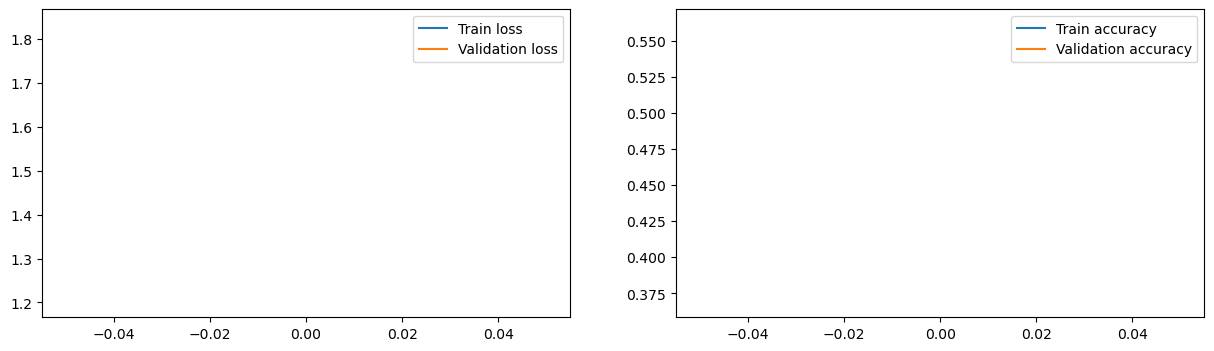

KeyboardInterrupt: 

In [5]:
# Define variable to track the highest running accuracy
top_val_acc = 0
count = 0

# Define loss and optimiser
loss = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)


# Iterate over the number of epochs
n_epochs = 10
model.train()
for n in range(n_epochs):
    epoch_start = time.time()
    tot_train_loss = 0.0
    train_correct = 0

    # Train our CNN
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        model_pred = model(X)
        loss_value = loss(model_pred, y)
        tot_train_loss += loss_value.item() * X.size(0)
        loss_value.backward()
        optimiser.step()
        optimiser.zero_grad()

        predicted_class = torch.argmax(model_pred, dim=1)
        train_correct += torch.sum((predicted_class == y).float())

    train_loss = tot_train_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)

    # Validate our CNN
    tot_val_loss = 0.0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            model_pred = model(X)
            loss_value = loss(model_pred, y)
            tot_val_loss += loss_value.item() * X.size(0)
            predicted_class = torch.argmax(model_pred, dim=1)
            val_correct += torch.sum((predicted_class == y).float())

    model.train()

    val_loss = tot_val_loss / len(val_loader.dataset)
    val_accuracy = val_correct / len(val_loader.dataset)

    # Track time it takes to complete each epoch
    epoch_time = time.time() - epoch_start

    # Store metrics
    train_losses_list.append(train_loss)
    val_losses_list.append(val_loss)
    train_acc_list.append(train_accuracy)
    val_acc_list.append(val_accuracy)

    # Checkpoint the best model
    if val_accuracy > top_val_acc:
        torch.save(model, 'top_cnn_model')
        top_val_acc = val_accuracy
        count = 0
    else:
        count += 1

    # Printouts and plotting
    clear_output(wait=True)
    print(f"Epoch: {n+1}/{n_epochs} (Time: {epoch_time:.2f}s), "
          f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}, "
          f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    plt.plot(train_losses_list, label='Train loss')
    plt.plot(val_losses_list, label='Validation loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(torch.tensor(train_acc_list).cpu(), label='Train accuracy')
    plt.plot(torch.tensor(val_acc_list).cpu(), label='Validation accuracy')
    plt.legend()
    plt.show()


print("Training complete. Best validation accuracy:", top_val_acc)


# Reload data and CNN model for next test

In [6]:
# Hyperparameters
batch_size = 512

# Normalization parameters for CIFAR-10 (standard)
# These are the per-channel means and stds computed over the CIFAR-10 dataset
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Transformations for the training data
transform_train = transforms.Compose([
 #   transforms.RandomCrop(32, padding=4),
 #   transforms.RandomHorizontalFlip(),
 #   transforms.RandomRotation(15),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
#    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])

# Transformations for the testing data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



# Load training and validation datasets
trainset_full = datasets.CIFAR10(root='./CIFAR10_data/', train=True, download=True, transform=transform_train)
#trainset_partial = Subset(trainset_full, list(range(3000)))
valset_full = datasets.CIFAR10(root='./CIFAR10_data/', train=False, download=True, transform=transform_test)
#valset_partial = Subset(valset_full, list(range(3000)))

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(trainset_full, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset_full, batch_size=batch_size, shuffle=False)

# Class names
class_names = trainset_full.classes

# Define CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Five convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding = 1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding = 1, bias=False)

        # Apply batchnorm
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.batchnorm5 = nn.BatchNorm2d(1024)

        # Define the ReLU
        self.ReLU = nn.ReLU()

        # Define the maxpooling layer
        self.maxpooling = nn.MaxPool2d(2)

        # Define the dropout layer
        self.dropout = nn.Dropout(p=0.1)

        # Define global adaptive average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)  # outputs (B,512,1,1)

        # Define fully connected layer
        self.fc  = nn.Linear(1024, 10)


    def forward(self, x):

        # Apply Conv followed by ReLU, then max pooling and drop out for each layer.
        x = self.ReLU(self.conv1(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm1(x))

        x = self.ReLU(self.conv2(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm2(x))

        x = self.ReLU(self.conv3(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm3(x))

        x = self.ReLU(self.conv4(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm4(x))

        x = self.ReLU(self.conv5(x))
        x = self.maxpooling(x)
        x = self.dropout(self.batchnorm5(x))

        # Apply global adaptave average pooling
        x = self.gap(x)              # (B,512,1,1)

        # Reshape for fully connected layer
        x = x.view(x.size(0), 1024)   # (B,512)

        # Apply fully connected layer
        return self.fc(x)


# Initialize the NN
model = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store running losses and accuracies of both datasets
train_losses_list, val_losses_list = [], []
train_acc_list, val_acc_list = [], []

Files already downloaded and verified
Files already downloaded and verified


# Testing our Final CNN with a learning rate scheduler

Epoch: 1/30 (Time: 40.85s), Training Loss: 1.685, Training Accuracy: 0.406, Validation Loss: 1.121, Validation Accuracy: 0.601


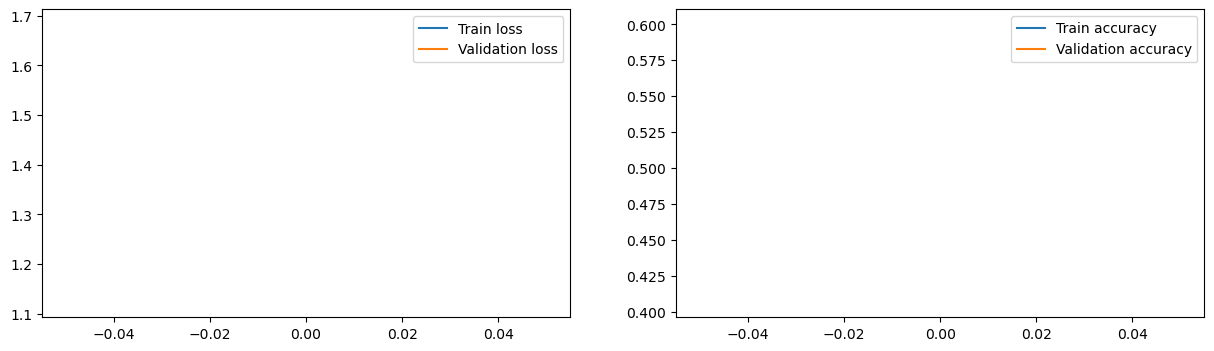

KeyboardInterrupt: 

In [7]:
# Variable to track the highest running accuracy
top_val_acc = 0
count = 0

# Define loss, optimiser, and LR scheduler
loss = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=2)

n_epochs = 30
model.train()

# Iterate over the number of epochs
for n in range(n_epochs):
    epoch_start = time.time()
    tot_train_loss = 0.0
    train_correct = 0

    # Train our CNN model
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        model_pred = model(X)
        loss_value = loss(model_pred, y)
        tot_train_loss += loss_value.item() * X.size(0)

        loss_value.backward()
        optimiser.step()
        optimiser.zero_grad()

        predicted_class = torch.argmax(model_pred, dim=1)
        train_correct += torch.sum((predicted_class == y).float())

    train_loss = tot_train_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)

    # Validate our CNN model
    tot_val_loss = 0.0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            model_pred = model(X)
            loss_value = loss(model_pred, y)
            tot_val_loss += loss_value.item() * X.size(0)
            predicted_class = torch.argmax(model_pred, dim=1)
            val_correct += torch.sum((predicted_class == y).float())
    model.train()

    val_loss = tot_val_loss / len(val_loader.dataset)
    val_accuracy = val_correct / len(val_loader.dataset)
    scheduler.step(val_loss)

    # Record time it takes to complete each epoch
    epoch_time = time.time() - epoch_start

    # Store metrics
    train_losses_list.append(train_loss)
    val_losses_list.append(val_loss)
    train_acc_list.append(train_accuracy)
    val_acc_list.append(val_accuracy)

    # Checkpoint the best model
    if val_accuracy > top_val_acc:
        torch.save(model, 'top_cnn_model')
        top_val_acc = val_accuracy
        count = 0
    else:
        count += 1

    # Printouts and plotting
    clear_output(wait=True)
    print(f"Epoch: {n+1}/{n_epochs} (Time: {epoch_time:.2f}s), "
          f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}, "
          f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    plt.plot(train_losses_list, label='Train loss')
    plt.plot(val_losses_list, label='Validation loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(torch.tensor(train_acc_list).cpu(), label='Train accuracy')
    plt.plot(torch.tensor(val_acc_list).cpu(), label='Validation accuracy')
    plt.legend()
    plt.show()


print("Training complete. Best validation accuracy:", top_val_acc)


# Q2. [15 marks] Report analyzing and discussing your CNN model


### Overview

Once you are content with the perfomance of your model write a concise report (equivalent of max 2 pages A4 without figures) below detailing the following.
- Walk me through the different development stages of your final model, including the different things you tried to improve training and or generalization.
- Discuss your final model and its train versus test accuracy, Make sure to provide plots of the training and test loss throughout training and comment on them, e.g., do you observe any underfitting or overfitting?
- Discuss where you think the key bottlenecks of your model are in terms of compute and generalization and what you would do moving forward to improve performance.

Note: you should support your assertions and claims with experimental evidence. This question is worth 15 marks, you will recieve marks for
 - your analysis of the performance of your model,
 - the clarity and logic of your report: in particular, what steps did you pursue to improve model performance and why?
 - The accuracy of your reflections and conclusions.
 - The quality of the empirical evidence, particularly in the form of graphs and plots, that you provide.

### Your report

# PART II
In this part of the coursework we return to basics and develop the key classes (layers) and functions used to build and train a CNN from scratch, based on NumPy. You can use Pytorch to test your code, e.g., by comparing the outputs of your layer with the equivalent in Pytorch.

# Q3. [10 marks] Combining softmax with cross entropy


### Overview

Our goal is to train a model which outputs class predictions given a feature vector. One way we can achieve this is by designing our model so that it outputs a probability mass function over the possible classes in our dataset. This can be achieved using the softmax function.


#### Softmax function:
Let $c$ be the number of different class labels in our data. Recall, given an input vector $z \in \mathbb{R}^c$, that the $i$th output (for $i \in [c]$) of the softmax function, which we denote as $\sigma: \mathbb{R}^c \rightarrow \mathbb{R}^c$, is
$$\sigma_i(x) = \frac{\exp(z_i)}{ \sum_{j=1}^c \exp(z_j)}.$$
Note for any input $z$ we have $\sigma_i(z)\geq 0$, moreover, by construction $\sum_{i \in [c]} \sigma_i(z) = 1$. Therefore $\sigma(z)$ defines a probability mass function where we can interpret $\sigma_i(z)$ as the probability assigned to the event that the label of $z$ is $i \in [c]$. Finally, it is common to compute softmax as follows: if $z^* = max_{i \in [c]}z_i$ then
$$
 \sigma_i(z) = \frac{\exp(z_i- z^*)}{ \sum_{j=1}^c \exp(z_j - z^*)}.
$$
This helps with the numerical stability of computing $e^x$ for large x by ensuring x is at most $0$.


#### The cross entropy loss:
In order to measure the performance of our model we need to define a loss function. For multiclass classification a popular and natural choice is to use the cross entropy loss, which we now motivate and define. Consider probability distributions (or mass functions) over $c$ objects (we denote these objects using the set $[c]$). To this end let $p, q$ be two mass functions on $[c]$, which we can equivalently think of as vectors $p,q \in [0,1]^c$ where the $i$th element is the probability assigned to $i \in [c]$. The *cross entropy* between $p$ and $q$ is defined as
$$
H(p, q) = - \sum_{i \in [c]} p_i \log(q_i),
$$
note this is non-negative and is non-symmetric. A useful identity for understanding the cross entropy is the following,
$$
H(p,q) = H(p,p) + D_{KL}(p || q),
$$
where here $D_{KL}$ is a scalar valued function (called the Kullback Leibler function) which measures the dissimilarity between $p$ and $q$. $D_{KL}$ is non-negative and moreover is zero if and only if $p=q$. We won't go into this in any more detail, suffice to say this identity implies that the cross entropy is minimized when $p = q$.

We can use cross entropy to define a loss function for our model. To this end, for $p$ we use the one hot encoding of a label $y \in [c]$, which we denote $\tilde{y} \in \{0,1\}^c$: this is a probability mass function over the class labels with all the mass concentrated on just one class (the true class of the input). Using softmax as our output layer, we can ensure our network outputs a vector $\hat{y} \in [0,1]^c$ that encodes a probability mass function over the labels and substitute this in for $q$. Therefore the accuracy of our prediction for a given example can be measured as
$$
\begin{align*}
H(\tilde{y}, \hat{y}) = - \sum_{i \in [c]} \tilde{y_i} \log(\hat{y_i}) = - \log(\hat{y_y}).
\end{align*}
$$
As a result, we define the *cross entropy loss* as $C_E(y, \hat{y}):= -\log(\hat{y}_{y}) $. Note that if $\hat{y_y}$ is close to 1 then the loss is close to 0, whereas if $\hat{y_y}$ approaches $0$ then the loss diverges. Note: to avoid numerical issues it is sensible to clip $\hat{y_y} \geq \epsilon > 0$. The total loss is then the average cross entropy loss over the batch.



#### Objective
Our goal is to implement a combined softmax cross entropy (SCE) class with the following member functions.
- A softmax member function which computes the softmax function on an input tensor.
- A cross_entropy function which calculates the average cross entropy between the predicted labels and the true labels.
- A backward member function which returns the error signal for the previous layer $\delta_{new}$ given the error signal $\delta$ from the layer above. This member function should also store down as member variables the gradient with respect to the biases and weights.
- A backward function which computes the gradient or derivative of the average cross entropy with respect to the input of the SCE layer.

### Questions

<ol type = "A">
  <li> Using the definition above and the comments in the code, complete the definition of the softmax method for the SCE class outlined below. For numerical stability, make sure to shift down by the largest element before applying the exponential function!</li>
  <li> Using the definition above and the comments in the code, complete the definition of the cross_entropy method for the SCE class outlined below. We can't apply log to zero, so as discussed threshold the predictions from below away from zero.  </li>
  <li> As discussed in the overview, let $\tilde{y}$ denote the one hot encoding of a true label $y \in [c]$, i.e., $\tilde{y}_j = 1$ if $y = j$ and is $0$ otherwise. In the cell titled "Derivative of the softmax cross entropy layer", show that $\frac{\partial}{\partial z} C_E(y, \sigma(z)) = \sigma(z) - \tilde{y}$.</li>
  <li> Complete the definition of the backward member function for the SCE class outlined below. You should vectorize your code by taking advantage of broadcasting and avoid for loops!</li>
  <li> Demonstrate that your code works by designing some tests: in particular, in the cells below the heading "Test your code" describe what your tests are and demonstrate that your code passes your tests.</li>
</ol>

### C. Derivative of the softmax cross entropy layer

We want to show that
\begin{align}
\frac{\partial}{\partial z} C_E(y, \sigma(z)) = \sigma(z) - \tilde{y}
\end{align}
Since we already know that $C_E(y, \hat{y}):= -\log(\hat{y}_{y})$ we can notice that $ C_E(y, \sigma(z)) = log(\sigma_y(z))$. As this is a composite function we use the chain rule to derive the softmax cross entropy layer. We denote $s = \sigma(z)$ as the vector of softmax outputs and $L(s) = -log(s_y)$, where y is the true label, to allow for easier reading and computation. we want to now compute,
\begin{align}
\frac{\partial L}{\partial z} = \frac{\partial L}{\partial s} \cdot \frac{\partial s}{\partial z}
\end{align}
for this we need, the gradient of the loss $\frac{\partial L}{\partial s}$ and the jacobian of the softmax function $\frac{\partial s}{\partial z}$.

We first derive the loss with respect to the Softmax output, the loss is defined as,
\begin{align}
L(s) = -log(s_y)
\end{align}
This is a function of the softmax vector s, but we are only interested in the y-th component so we have,

\begin{align}
\frac{\partial L}{\partial s_i} = \
\begin{cases}
-\frac{1}{s_i}, \quad \text{if} \quad i = y \\
0, \qquad \text{otherwise}
\end{cases}
\end{align}

This produces a vector that is zero everywhere except at y, where it is $\frac{-1}{s_y}$. \
The softmax function is defined as

\begin{align}
\sigma_i(x) = \frac{exp(z_i)}{\sum_{j=1}^c exp(z_j)}
\end{align}

We need to compute the jacobian matrix of the softmax function $J \in \mathbb{R} ^{c \times c}$ where,
\begin{align}
J_{i,j} = \frac{\partial s_i}{\partial z_j}
\end{align}

This results in:
\begin{align}
\frac{\partial s_i}{\partial z_j} =
\begin{cases}
s_i(1-s_i), \quad \text{if} \quad i=j \\
-s_i s_j, \quad \text{if} \quad  i \neq  j
\end{cases}
\end{align}

Using the chain rule we can now solve,
\begin{align}
\frac{\partial L}{\partial z_j} = \sum_{i=1}^c \frac{\partial L}{\partial s_i} \cdot \frac{\partial s_i}{\partial z_j}
\end{align}

Since we are only interested in the cases where $i=y$ we have,

\begin{align}
\frac{\partial L}{\partial z_j} = \frac{\partial L}{\partial s_y} \cdot \frac{\partial s_y}{\partial z_j} =  -\frac{1}{s_y} \cdot  \frac{\partial s_y}{\partial z_j}
\end{align}

now for $\frac{\partial s_y}{\partial z_j}$ we have two cases,

- if $j=y$,
\begin{align}
\frac{\partial s_y}{\partial z_j} = s_y(1-s_y)
\end{align}
therefore,
\begin{align}
\frac{\partial L}{\partial z_y} = -\frac{1}{s_y} \cdot s_y(1-s_y) = s_y -1
\end{align}
- if $j \neq y$,
\begin{align}
\frac{\partial s_y}{\partial z_j} = -s_ys_j
\end{align}
therefore,
\begin{align}
\frac{\partial L}{\partial z_y} = -\frac{1}{s_y} \cdot (-s_ys_j) = s_j
\end{align}

Finally, since $\tilde{y}$ is denoted as the one hot encoding of a true label $y \in [c]$, we can see that when $i=j$ $\tilde{y}_i = 1$ and 0 when $i \neq j$. Subbing back in $s = \sigma(z)$ we see that we have exactly,
\begin{align}
\sigma(z) - \tilde{y}
\end{align}

as such we have shown that
\begin{align}
\frac{\partial}{\partial z} C_E(y, \sigma(z)) = \sigma(z) - \tilde{y}
\end{align}
as required.

### A class for the softmax cross entropy layer (SCE)

In [8]:
class SCE:
  """
  Class implementing a softmax layer feeding into the cross entropy loss function.
  """

  def __init__(self):
    self.eps = 1e-10 # Used to clip softmax inputs and avoid numerical instability
    self.z = None # Stores input tensor to the softmax layer during forward pass (needed for the backward pass)
    # Has no model parameters

  def softmax(self, z):
    # A
    """
    Computes the softmax

    Parameters:
    -----------
    z : numpy array of shape (batch_size, num_classes)
        The input to the softmax function.

    Returns:
    --------
    y_pred: a numpy array of shape (batch_size, num_classes)
        Softmax applied to the each row of z
    """
    self.z = z # Store for use
    z_shifted = z - np.max(z, axis = 1, keepdims = True) # Shifted for numerical stability
    exp_z = np.exp(z_shifted)
    y_pred = exp_z / np.sum(exp_z, axis = 1, keepdims = True)
#    print(y_pred.shape) # Check shape of y_pred matches with (batch_size, num_classes) for testing and verification purposes
    return y_pred

  def cross_entropy(self, y_true, y_pred):
    # B
    """
    Computes the average cross-entropy loss for one-hot encoded predictions given scalar
    target labels.

    Parameters:
    -----------
    y_true : numpy array, type int, shape = (batch_size,)
          True labels or targets.
    y_pred : numpy array, type float, shape = (batch_size, num_classes)
          Predicted distribution over classes for each example.

    Returns:
    --------
    av_loss : float
        The average cross-entropy loss across the batch.
    """
    y_pred = np.clip(y_pred, self.eps, 1.0)
    log_prob = -np.log(y_pred[np.arange(len(y_true)), y_true])
    av_loss = np.mean(log_prob)
#    print(type(av_loss)) # Ensure we are outputting a float
    return av_loss

  def backward(self,y_true):
    # D
    """
    Computes the initial error signal delta (gradient of C_E(y, sigma(z)) with
    respect to the input of the softmax layer z

    Parameters:
    -----------
    y_true : numpy array, type int, shape = (batch_size,)
        True labels or targets.

    Returns:
    ----------
    delta : numpy array of shape (batch_size, num_classes)
        The gradient of L (average cross entropy loss) with respect to z
    """
    y_pred = self.softmax(self.z)
    batch_size, num_classes = y_pred.shape
    y_one_hot = np.zeros_like(y_pred)
    y_one_hot[np.arange(batch_size), y_true] = 1
    delta = (y_pred - y_one_hot) / batch_size
#    print(delta.shape) #Check shape of delta is (batch_size, num_classes)
    return delta




### E. Testing your SCE class

In order to test the validity of our functions softmax, cross_entropy and backward, we decided to use PyTorch to ensure that our functions were mathematically correct and producing the expected outputs. We first produced a set of sample data and evaluated it using our implementation and PyTorch's built-in functions. For each of these functions we compared the output produced by our code and PyTorch and found that our Softmax, Cross_entropy, and backwards functions matched with PyTorch's implementations. These outputs confirmed that our functions were mathematically correct and have been implemented as required.

In [9]:
# Demonstration your code works
import torch.nn.functional as F


z_np = np.array([[2,1,0.1]])
y_np = np.array([0])

z_torch = torch.tensor(z_np, dtype=torch.float32, requires_grad = True)
y_torch = torch.tensor(y_np, dtype=torch.long)

loss_torch = F.cross_entropy(z_torch, y_torch, reduction='mean')
loss_torch.backward()

softmax_torch = F.softmax(z_torch,dim=1).detach().numpy()
loss_torch_val = loss_torch.item()
grad_torch = z_torch.grad.detach().numpy()

sce = SCE()
softmax_np = sce.softmax(z_np)
loss_np = sce.cross_entropy(y_np, softmax_np)
grad_np = sce.backward(y_np)

print("------------- Softmax testing -------------")
print("My softmax:", softmax_np)
print("Torch softmax:", softmax_torch)
print("Match:", np.allclose(softmax_np, softmax_torch, atol= 1e-6))

print("------------- Cross Entropy testing -------------")
print("My Cross entropy:", loss_np)
print("Torch Cross entropy:", loss_torch_val)
print("Match:", np.allclose(loss_np, loss_torch_val, atol= 1e-6))

print("------------- Backward member testing -------------")
print("My Bacward member:", grad_np)
print("Torch Backward member:", grad_torch)
print("Match:", np.allclose(grad_np, grad_torch, atol= 1e-6))

------------- Softmax testing -------------
My softmax: [[0.65900114 0.24243297 0.09856589]]
Torch softmax: [[0.6590012  0.24243298 0.09856589]]
Match: True
------------- Cross Entropy testing -------------
My Cross entropy: 0.4170300162778335
Torch Cross entropy: 0.4170299470424652
Match: True
------------- Backward member testing -------------
My Bacward member: [[-0.34099886  0.24243297  0.09856589]]
Torch Backward member: [[-0.34099883  0.24243298  0.0985659 ]]
Match: True


# Q4. [4 marks] Implementing a ReLU layer

### Overview

In this question you will implement a ReLU layer. You have already done this in one form during your lab assignments via functions, the only difference here is that you will implement it as a class. Recall given a scalar z that $\phi(z) := ReLU(z) = max(0,z).$ To apply ReLU to a tensor it is simply applied to each element of the tensor independently Your ReLU layer will have the following member functions.
- A forward member function which applies ReLU to every element of the input tensor.
- A backward member function which returns the error signal for the previous layer $\delta_{new}$ given the error signal
$\delta$ from the layer above.

### Questions

<ol type = "A">
  <li> Complete the definition of the forward function for the ReLU class outlined below. You should take advantage of NumPy broadcasting and avoid for loops. Also, you will need to store the input to the forward pass in a member variable so that it can be used for the backward pass.</li>
  <li> Although ReLU is not differentiable, it is differentiable everywhere other than at zero (it is almost everywhere differentiable).  As is standard in software packages, we define the gradient of ReLU at $0$ to be $0$.Given a scalar $z \in \mathbb{R}$, as per our standard notation let $a = \phi(z) \in \mathbb{R}$ and $\delta=\frac{\partial L}{\partial a} \in \mathbb{R}$. In the cell under the title "Derivative with respect to the input" show that
  $$
  \frac{\partial L}{\partial z} =  \delta \mathbb{1}(z > 0).
  $$
  <li> Complete the definition of the backward function. Hint: you should be able to achieve this by mutating $\delta$ directly, or a copy of it, using boolean indexing. Again avoid the use of for loops. </li>
  <li> Describe and demonstrate your tests for your ReLU class in the space provided below.</li>
</ol>

### B. Derivative with respect to the input

Using the chain rule we can compute the derivative with respect to the input as follows,
\begin{align}
\frac{\partial L}{\partial z} = \frac{\partial L}{\partial a} \cdot \frac{d a}{d z} = \delta \cdot \frac{d \phi(z)}{dz}
\end{align}
since $\phi(z) = max(0,z)$ we have that,
\begin{align}
\frac{d \phi(z)}{dz} =
\begin{cases}
1,\quad \text{if} \quad z>0 \\
0,\quad \text{if} \quad z<0 \\
\text{undefined} \quad \text{if} \quad z = 0 \\
\end{cases}
\end{align}
if we define the derivative of $z=0$ to be 0 for convenience, as it is standard in many deep learning frameworks, we can now write,
\begin{align}
\frac{d \phi(z)}{dz} = \mathbb{1}(z > 0)
\end{align}
Substituting this back into our original equation gives,

\begin{align}
\frac{\partial L}{\partial z} =  \delta  \mathbb{1}(z > 0)
\end{align}
as required.

### A class for ReLU

In [10]:
class ReLU:
  """
  Class implementing a ReLU layer for a neural network.
  """
  def __init__(self):
    self.z = None # Store input during forward pass for the backward pass
    # Has no model parameters

  def forward(self, z):
    """
    Applies the ReLU function element-wise to the input z, also stores the input
    z for the backward pass.

    Parameters:
    -----------
    z : input numpy array
        The input to the ReLU layer

    Returns:
    ----------
        numpy array of with the same shape as z
        z with ReLU applied elementwise
    """
    self.z = z
    return np.maximum(0, z)

  def backward(self, delta):
    """
    Computes the error signal for the ReLU layer given the error signal
    from the next layer.

    Parameters:
    -----------
    delta : numpy array
        Error signal from the next layer

    Returns:
    ----------
    delta_new : numpy array of with the same shape as self.z_in
        Error signal propagated to the previous layer
    """
    delta[self.z <= 0] = 0
    return delta


### D. Testing your ReLU class

Below we have defined three sperate test to allow us to verify that the ReLU function is performing as expected. The first test allows us to confirm that if we provided the function with negative numbers these would change to zero and positive inputs pass through unchanged. The backward test allows us to check that only neurons whose inputs were positive during the forward pass actually receive any back‑propagated error signal, and any inputs that are at or below zero has the gradient completely blocked and doesn’t propagate backward. For the final test we decided to use random arrays to ensure that we are not relying on one example and that our function is checking every entry not just the few that we listed in our first function.

In [11]:
# Test that a mixture of both negative and positive inputs produces the appropriate output
def test_relu_forward():
    relu = ReLU()
    z = np.array([-1, 0, 3, -2, 4.5])
    out = relu.forward(z)
    expected = np.array([0, 0, 3, 0, 4.5])
    print(np.array_equal(out, expected), f"forward({z}) expected {expected}, got {out}")

def test_relu_backward_simple():
    relu = ReLU()
    z = np.array([-2, 0, 2, 5])
    relu.forward(z)
    delta = np.ones_like(z)
    delta_new = relu.backward(delta)
    expected = np.array([0, 0, 1, 1])
    print(np.array_equal(delta_new, expected), f"backward on {z} expected {expected}, got {delta_new}")

def test_relu_backward_preserves_shape_and_dtype():
    relu = ReLU()
    z = np.random.randn(3,4).astype(np.float32)
    relu.forward(z)
    delta = (np.random.randn(3,4) * 5).astype(np.float32)
    delta_new = relu.backward(delta)
    mask = (z <= 0)
    print("no gradient leaked through non-positive z = ",np.all(delta_new[mask] == 0))

# Run tests
test_relu_forward()
test_relu_backward_simple()
test_relu_backward_preserves_shape_and_dtype()

True forward([-1.   0.   3.  -2.   4.5]) expected [0.  0.  3.  0.  4.5], got [0.  0.  3.  0.  4.5]
True backward on [-2  0  2  5] expected [0 0 1 1], got [0 0 1 1]
no gradient leaked through non-positive z =  True


# Q5. [6 marks] Implementing a linear layer

### Overview

Here we implement a linear layer, in particular, given an input matrix $z \in \mathbb{R}^{N \times D}$, a weight matrix $w \in \mathbb{R}^{D \times M}$ and a bias vector $b \in \mathbb{R}^M$ then the forward pass of the linear layer computes an output
$$
a = zw + b^T \in \mathbb{R}^{N \times M}.
$$
Note that in the above we adopt standard NumPy broadcasting rules to perform the addition and we think of
- $N$ as the size of the batch,
- $D$ as the dimension (or degrees of freedom) of each input feature,
- and $M$ as the width of our linear layer.

Your linear layer class will have the following member functions.
- An init method which initializes the weights and biases.
- A forward member function which computes the output matrix $a$ as defined above.
- A backward member function which returns the error signal for the previous layer $\delta_{new}$ given the error signal $\delta$ from the layer above. This member function should also store down as member variables the gradient (tensor of partial derivatives) of the loss with respect to the biases and weights.

### Questions

<ol type = "A">
  <li> Complete the definition of the forward function for the linear class outlined below. Make sure to store the input during the forward pass in a member variable so that it can be used in the backward pass</li>
  <li> In the space provided below (Derivative with respect to the biases), show that
  $$
  \frac{\partial L}{\partial b} = \delta^T 1_N.
  $$
  </li>
  <li> In the space provided below (Derivative with respect to the weights), show that
  $$
  \frac{\partial L}{\partial w} = z^T \delta.
  $$
  </li>
 <li> In the space provided below (Derivative with respect to the inputs), show  that
  $$
  \frac{\partial L}{\partial z} = \delta w^T
  $$
  </li>
  <li> Complete the definition of the backward function. You will need to compute and store in member variables the gradient with respect to the weights and biases - you must call these member variables dw and db respectively.
  <li> Describe and demonstrate your tests for the linear class in the space provided below.</li>
</ol>

### B. Derivative with respect to the biases

We can see that component-wise we have
\begin{align}
a_{ij} = (zw)_{ij} + b_j
\end{align}
and therefore
\begin{align}
\frac{\partial L}{\partial b_j} = \sum^N_{i=1} \sum^M_{k=1} \frac{\partial L}{\partial a_{ik}} \cdot \frac{\partial a_{ik}}{\partial b_j}
\end{align}
Notice that,

\begin{align}
\frac{\partial a_{ij}}{\partial b_j} = 1
\end{align}

and $\partial a_{ik}/\partial b_j$ = 0 when $k \neq j$. Therefore by the chain rule we now have,

\begin{align}
\frac{\partial L}{\partial b_j} = \sum^N_{i=1} \sum^M_{k=1} \frac{\partial L}{\partial a_{ik}} \cdot \frac{\partial a_{ik}}{\partial b_j}  = \sum^N_{k=1}\frac{\partial L}{\partial a_{ij}} \cdot 1 = \sum^N_{i=1} \delta_{ij}
\end{align}
In vector matrix form if $\delta \in \mathbb{R}^{N \times M}$ and $1_N \in \mathbb{R}^N$ is a vector of all ones, then the vector M with j-th entry of $\sum_i \delta_{ij}$ is,
\begin{align}
\delta^T 1_N
\end{align}
therefore we have,
\begin{align}
\frac{\partial L}{\partial b} = \delta^T 1_N
\end{align}
as required.

### C. Derivative with respect to the weights

firstly we can see that,
\begin{align}
\frac{\partial a_{ij}}{\partial w_{kj}} = z_{ik}
\end{align}
and that it is zero when $k' \neq k$. Therefore by the chain rule we have that
\begin{align}
\frac{\partial L}{\partial w_{kj}} = \sum^N_{i=1}\frac{\partial L}{\partial a_{ij}} \cdot \frac{\partial a_{ij}}{\partial w_{kj}} = \sum^N_{i=1} \delta_{ij} z_{ik}
\end{align}
summing all these up for $k = 1,...,D$ and $j = 1,...,M$ gives the $D \times X$ matrix,

\begin{align}
\frac{\partial L}{\partial w} = z^T \delta.
\end{align}
as required.

### D. Derivative with respect to the input

We can see that,
\begin{align}
\frac{\partial a_{ij}}{\partial z_{ik}} = w_{kj}
\end{align}

by the chain rule we now have,
\begin{align}
\frac{\partial L}{\partial z_{ik}} = \sum^M_{j=1} \frac{\partial L}{\partial a_{ij}} \frac{\partial a_{ij}}{\partial z_{ik}} = \sum^M_{j=1} \delta_{ij}w_{kj}
\end{align}
summing all these up for $i = 1,...,N$ and $k = 1,...,D$ gives the matrix
\begin{align}
\frac{\partial L}{\partial z} = \delta w^T
\end{align}
as required.

### A class for a linear layer

In [12]:
class Linear:
  """
  Class implementing a linear layer for a neural network
  """
  def __init__(self, in_features, out_features):

    # Implement He-scaling
    scale = np.sqrt(2/ in_features)
    # Define parameters
    self.w = (np.random.randn(in_features, out_features) * scale) # EXTRA: how could we scale this initialization better
    self.b = np.zeros(out_features)
    # Define gradient of parameters
    self.dw = None
    self.db = None
    # Store input during forward pass for the backward pass
    self.z = None


  def forward(self, z):
    # A
    """
    For a given input tensor z computes z@w + b (take advantage of broadcasting!)

    Inputs:
    -----------
    z : input numpy array of shape (batch_size, in_features)

    Returns:
    ----------
        numpy array of shape (batch_size, out_features)
    """
    self.z = z
    a = z @ self.w + self.b
    return a

  def backward(self, delta):
    # E
    """
    Computes the error signal for a layer given the error signal
    from the next layer. Also computes / stores the gradient of the loss
    with respect to the parameters of the layer, i.e., dw and db.

    Inputs:
    -----------
    delta : numpy array of shape (batch_size, out_features)
        Error signal from the next layer

    Returns:
    ----------
    delta_new : numpy array of with the same shape as self.z
        Error signal propagated to the previous layer
    """
    self.dw = self.z.T @ delta
    self.db = np.sum(delta, axis=0)
    delta_new = delta @ self.w.T
    return delta_new

### F. Testing your linear layer

Below we designed tests to ensure our Linear layer functions were operating as expected. First we tested our forward pass by fixing W and b to known values and verified that forward(z) returned exactly $zw + b$. We additionally designed a test that checked the gradient produced by our backward  function. We accomplished this by sampling random weight and bias values, computing their gradients analytically via our backward method, estimating the same gradients numerically, and then comparing the two to observe any potential discrepancies. We found that there was practically no difference, confirming that our functions were working correctly.

In [13]:
# Define parameters
np.random.seed(0)
N, D, M = 5, 4, 3
z     = np.random.randn(N, D)
delta = np.random.randn(N, M)       # partial L/ partial a
U     = np.random.randn(D, M)       # direction for w
V     = np.random.randn(M)          # direction for b
eps   = 1e-5
layer = Linear(D, M)

# Test backward function
out = layer.forward(z)
dz = layer.backward(delta)
dw_analytic, db_analytic = layer.dw, layer.db

# Compute directional derivative
D_analytic = np.sum(dw_analytic * U) + np.sum(db_analytic * V)

# Define numeric directional derivative
def loss_fn(w, b):
    # loss = sum( a * delta )
    a = z @ w + b
    return np.sum(a * delta)

# Apply numeric directional derivative
D_plus  = loss_fn(layer.w + eps * U, layer.b + eps * V)
D_minus = loss_fn(layer.w - eps * U, layer.b - eps * V)
D_num   = (D_plus - D_minus) / (2 * eps)

# Check both numericla and analytical match
print("Directional check error:", abs(D_num - D_analytic))
print(abs(D_num - D_analytic) < 1e-7)

Directional check error: 1.921840464547131e-11
True


# Q6. [20 marks] Implementing a 2D convolution layer

### Overview

We start by presenting the 2d-convolution operation (as used in machine learning) assuming a fixed stride of one and no dilation. Consider two four dimensional tensors $x \in \mathbb{R}^{N \times C_{in} \times H_{in} \times V_{in}}$ and $u \in \mathbb{R}^{C_{out} \times C_{in} \times K_1 \times K_2}$, where we assume $K_1 \leq H_{in}$ and $K_2 \leq V_{in}$. Let $H_{out}= H_{in} - K_1 +1$ and $V_{out}= V_{in} - K_2 +1$. The convolution of $x$ with $u$ produces a tensor $(x * u) \in \mathbb{R}^{N \times C_{out} \times H_{out} \times V_{out}}$ whose entries are calculated as follows,
$$
(x*u)_{n,o,h,v} = \sum_{c =0}^{C_{in}-1} \sum_{i = 0}^{K_1-1} \sum_{j=0}^{K_2-1} u_{o, c, i, j} x_{n,c, h+i, v+j},
$$
note in the above we use indexing starting from $0$ as is standard in Python. Note also that this is not a symmetric operation, indeed $x*u \neq u*x$. We think of the lefthand argument $x$ as the *input* and the righthand argument $u$ as the *kernel* or *filter* which is applied to the input. A 2D convolution layer with stride 1, no dilation and square kernel of size $K$ convolves an input tensor $z \in \mathbb{R}^{N \times C_{out} \times H_{out} \times V_{out}}$ with weights $w \in R^{C_{out} \times C_{in} \times K \times K}$ and adds a bias $b\in R^{C_{out}}$ term to produce an output tensor
$$
a = (z * w) + b.
$$
Note that in the expression above we again adopt standard broadcasting rules to perform the addition, equivalently
$$
a_{n, o, h, v} = b_o + \sum_{c=0}^{C_{in}-1} \sum_{i =0}^{K-1} \sum_{j =0}^{K-1} w_{o,c,i,j} z_{n, c, h+i, v+j}.
$$
Our goal is to implement a computationally efficiently class for a 2d convolutional layer. This class will have the following member functions or methods.
- An init method for initializing the key member variables including the weights $w$ and biases $b$.
- A conv2d operation which accepts an input tensor and a filter tensor and returns their 2d convolution. Note that we keep this seperate from our forward method as we will also be able to use it to compute gradients.
- A forward method which computes and returns $a = (z * w) + b$.
- A backward method which, given $\delta := \frac{\partial L}{\partial a}$ computes and returns $\delta_{new} := \frac{\partial L}{ \partial z}$. This method also computes and stores the parameter gradients $\frac{\partial L}{ \partial w}$ and $\frac{\partial L}{ \partial b}$.

### Notation for processing 4 dimensional arrays

We will use the following variables to denote the dimensions of our tensors.
* $N$ is the size of the batch
* $C_{in}$ is the number of input channels, $C_{out}$ is the number of output channels.
* $H_{in}$ is the height of the input tensor, $H_{out}$ is the height of the output tensor.
* $V_{in}$ is the width of the output tensor, $V_{out}$ is the width of the output tensor.
* $K$ is the dimension of our kernel, recall for simplicity we are assuming our kernel size is fixed.

Key tensors we will need to discuss are
* The input tensor, $z \in \mathbb{R}^{N\times C_{in} \times H_{in} \times V_{in}}$.
* The output tensor, $a \in \mathbb{R}^{N \times C_{out} \times H_{out} \times V_{out}}$.
* The tensor of weights (one filter per input-output channel pair), $w \in R^{C_{out} \times C_{in} \times  K \times K}$.
* The tensor of biases (one per output channel), $b \in \mathbb{R}^{C_{out}}$.
* The error signal from the next layer $\delta = \frac{\partial L}{ \partial a} \in \mathbb{R}^{N \times C_{out} \times H_{out} \times V_{out}}$.
* The error signal to be propagated to the previous layer $\delta_{new} = \frac{\partial L}{ \partial z} \in \mathbb{R}^{N \times C_{in} \times H_{in} \times V_{in}}$.

Care is needed for what follows so here we establish some standard usages for the indices we will use.

*   $n,m$ will be used as indices over the batch
*   $o,p$ will be used as indices over the output channel
*   $c,d$ will be used as indices over the input channel
*   $i,j,k,l$ will be used as indices over the kernel dimension
*   $g,h$ will be used as indices over the output height
*   $v,u$ will be used as indices over the output width
*   $q,r$ will be used as indices over the input height
*   $s,t$ will be used as indices over the input width

### Questions



<ol type = "A">
  <li> Implement the 2d convolution operation $(x*u)_{n,o,h,v} = \sum_{c =1}^{C_{in}} \sum_{i = 0}^{K_1-1} \sum_{j=0}^{K_2-1} u_{o, c, i, j} x_{n,o, h+i, v+j}$ as the member function conv2d of the Conv2D class defined below. Try to do this as efficiently as possible by minimizing the number of nested for loops. A simple implementation of conv2d requires 7 nested for loops, you can reduce this to two however if you are careful with broadcasting. </li>
  <li> Describe your approach to implementing conv2d in detail in the text cell titled "Description of 2d convolution operation" below. Feel free to include and highlight particular snippets of code.
  </li>
  <li> Implement the forward member function of the Conv2D class in order to compute $a = (z * w) + b$. You should call the member function conv2d and supply it with the appropriate arguments. </li>
  <li> In the cell marked "Derivative of the loss with respect to the biases" show that $\frac{\partial L}{\partial b_p} = \sum_{n=1}^N \sum_{h=1}^{H_{out}} \sum_{v = 1}^{V_{out}} \delta_{n,p,h,v}$. Comment on how $\frac{\partial L}{\partial b}$ can be computed efficiently with a single line of code and without using any for loops.</li>
  <li> For a given four dimensional tensor $x$, let $x'$ denote a tensor with the same elements as $x$ but with its first and second axes swapped, i.e., $x_{a,b,c,d} = x'_{b,a,c,d}$. In the cell marked "Derivative of the loss with respect to the weights", show that $\frac{\partial L}{\partial w} = (z'*\delta)'$.</li>
  <li> Let $\hat{w}$ denote the flipped version of $w$ in the following sense: the output and input channel axes are swapped and the height and width indices are flipped, i.e., $w_{o,c,i,j} = \hat{w}_{c,o,K-1-i, K-1-j}$. In addition, let $\tilde{\delta} \in \mathbb{R}^{N, C_{out}, H_{out}+K-1, V_{out} + K -1}$ denote the $K-1$ zero padded version of $\delta$, where each height and channel dimension is padded with $K-1$ zeroes on either side. In the cell marked "Derivative of the loss with respect to the inputs" prove that $\frac{\partial L}{\partial z} = \tilde{\delta}*\hat{w}$.</li>
  <li> Implement the backward method of the Conv2D class outlined below.</li>
  <li> Describe your tests for your Conv2D class and show it passes them in the space provided below.
</ol>

### B. Description of 2d convolution operation

The aim of our conv2d method is to perform a 2d convolution between an input tensor $z$ and a weight tensor $w$ in order to calculate the following,
\begin{align}
(x*u)_{n,o,h,v} = \sum_{c =0}^{C_{in}-1} \sum_{i = 0}^{K_1-1} \sum_{j=0}^{K_2-1} u_{o, c, i, j} x_{n,c, h+i, v+j},
\end{align}
We managed to achieve this using two nested python loops by using careful broadcasting over the kernel dimension i,j, and a single vectorized contraction over the input with dimension c.
First we compute the height and width of the output tensor along with the number of output channels C_out as follows,

    N, C_in, H_in, V_in = x.shape
    C_out, _, K1, K2 = u.shape
    H_out = H_in - K1 + 1
    V_out = V_in - K2 + 1

    conv_out = np.zeros((N, C_out, H_out, V_out))


this is so we ensure a already has the correct output shape we desire which is $(N, C_{out}, H_{out}, V_{out})$

Next we decided that rather than looping over each $(n,c,h,v)$ we noticed that for each fixed (i,j) in the $K \times K$,
\begin{align}
w_{o,c,i,j} z_{n, c, h+i, v+j}
\end{align}
was applied identically across each batch $n$, input channel $c$, output height $h$, and output width $v$, thus we were able to build the nested loop as follows,

    for i in range(K1):
        for j in range(K2):
            x_slice = x[:, :, i:i + h_out, j:j + V_out]
            u_slice = u[:, :, i, j]
            tmp = np.tensordot(x_slice, u_slice, axes=([1], [1]))
            conv_out += tmp.transpose(0, 3, 1, 2)
    return conv_out

where x_slice selected all $z_{n, c, h+i,v+j}$ at once and w_slice contained all the current $w_{o,c,i,j}$. we were then able to use these to sum over $c$ using tensordot to offload the iterations over $n,h$ and $v$ to avoid python loops. By using this structure we were able to avoid the unnecessary use of loops and optimised our code, producing the final convolution of $z$ and $w$.


### D. Derivative of the loss with respect to the biases

we want to show that $\frac{\partial L}{\partial b_p} = \sum_{n=1}^N \sum_{h=1}^{H_{out}} \sum_{v = 1}^{V_{out}} \delta_{n,p,h,v}$ to do this we will use the chain rule to solve,
\begin{align}
\frac{\partial L}{\partial b_p} = \sum_{n=1}^N \sum_{h=1}^{H_{out}} \sum_{v = 1}^{V_{out}} = \frac{\partial L}{\partial a_{n,p,h,v}} \cdot \frac{\partial a_{a,p,h,v}}{\partial b_p}
\end{align}


since we have that,
\begin{align}
a_{n,p,h,v} = (z \ast w)_{n,p,h,v} + b_p
\end{align}
we can see that,
\begin{align}
\frac{\partial a_{n,p,h,v}}{\partial b_p} = 1
\end{align}
furthermore since $L$ depends on $a$ we have that
\begin{align}
\frac{\partial L}{\partial a_{n,p,h,v}} = \delta_{n,p,h,v}
\end{align}
therefore we have that,
\begin{align}
\frac{\partial L}{\partial b_p} = \frac{\partial L}{\partial a_{n,p,h,v}} \cdot \frac{\partial a_{a,p,h,v}}{\partial b_p} = \sum_{n=1}^N \sum_{h=1}^{H_{out}} \sum_{v = 1}^{V_{out}} \delta_{n,p,h,v} \cdot 1 = \sum_{n=1}^N \sum_{h=1}^{H_{out}} \sum_{v = 1}^{V_{out}} \delta_{n,p,h,v}
\end{align}
as required.

we can efficiently compute $\frac{\partial L}{\partial b}$ without any python loops by summing up the 4 Dimensional delta tensor over the batch, height and width dimensions. The code would be as follows,

db = delta.sum(axis=(0, 2, 3))

since delta has shape $(N, C_{out}, H_{out}, V_{out})$ this code is summing over the batch, height and width dimensions as previously stated, avoiding any use of loops.


### E. Derivative of the loss with respect to the weights

we need to show that,
\begin{align}
\frac{\partial L}{\partial w_{o,c,i,j}} = \sum_{n=0}^{N-1} \sum_{h=0}^{H_{out}-1} \sum_{v=0}^{V_{out}-1} \delta'_{o,n,h,v} z'_{c,n,h+i,v+j}
\end{align}

first we define our tensors with swapped axis',
\begin{align}
z'_{c,n,h,v} = z_{n,c,h,v}, \qquad  \delta'_{o,n,h,v} = \delta_{n,o,h,v}
\end{align}

using out definition of 2d convolution we have,
\begin{align}
(z' \ast \delta')_{c,o,i,j}=  \sum_{n=0}^{N-1} \sum_{h=0}^{H_{out}-1} \sum_{v=0}^{V_{out}-1} \delta'_{o,n,h,v} z'_{c,n,h+i,v+j}
\end{align}
substituting the axis swapped $z'$ and $\delta'$ gives,
\begin{align}
(z' \ast \delta')_{c,o,i,j} = \sum_{n,h,v} \delta_{n,o,h,v} z_{n,c,h+1,v+j} = \frac{\partial L}{\partial w_{o,c,i,j}}
\end{align}
Swapping the axis' $(c,o)$ so that we can recover $(o,c,i,j)$ by utilising a transpose on these axis' gives,
\begin{align}
(z' \ast \delta')_{c,o,i,j} = ((z' \ast \delta')')_{o,c,i,j} = \frac{\partial L}{\partial w_{o,c,i,j}}
\end{align}
This gives exactly,
\begin{align}
\frac{\partial L}{\partial w} = (z' \ast \delta')'
\end{align}
as required.

### F. Derivative of the loss with respect to the input




first we begin my recalling that $\delta_{n,o,h,v} = \frac{\partial L}{\partial a_{n,o,h,v}}$. Then by the chain rule we have that,
\begin{align}
\frac{\partial L}{\partial z_{n,c,q,r}} = \sum_{o=0}^{C_{out}-1} \sum_{h=0}^{H_{out}-1} \sum_{v=0}^{V_{out}-1} \delta_{n,o,h,v} \frac{\partial a_{n,o,h,v}}{\partial z_{n,c,q,r}}
\end{align}
since
$$
a_{n, o, h, v} = b_o + \sum_{c=0}^{C_{in}-1} \sum_{i =0}^{K-1} \sum_{j =0}^{K-1} w_{o,c,i,j} z_{n, c, h+i, v+j}.
$$
we have that,
\begin{align}
\frac{\partial a_{n,o,h,v}}{\partial z_{n,c,q,r}} =
\begin{cases}
w_{o,c,h,v}, \quad \text{if} \quad  q= h+i \space \text{and} \space r = v+j \space \text{for some} \space 0 \leq i, j < K \\
0, \quad \text{otherwise}
\end{cases}
\end{align}
This is because a particular input $z_{n,c,q,r}$ only affects the activations $a_{n,o,h,v}$ whose kernel $(i,j)$ has exactly $(q,r)$.
Computing the chain rule and plugging in $h=q-i$ and $v=r-j$ then gives,
\begin{align}
\frac{\partial L}{\partial z_{n,c,q,r}} = \sum_{o=0}^{C_{out}-1} \sum_{i =0}^{K-1} \sum_{j =0}^{K-1} \delta_{n,o,q-i,r-j} \space w_{o,c,i,j}
\end{align}
Since we have that $\tilde{\delta} \in \mathbb{R}^{N, C_{out}, H_{out}+K-1, V_{out} + K -1}$ is the $K-1$ zero padded version of $\delta$, where each height and channel dimension is padded with $K-1$ zeroes on either side. Then for all valid $(q,r)$ we have that,
\begin{align}
\tilde{\delta}_{n, o, q-i+(K+1),r-j+(K+1)}
\begin{cases}
\delta_{n,o,q-i,r-j} \quad \text{if} \space 0 \leq q-i < H_{out}, 0 \leq r-j < V_{out} \\
0, \quad \text{otherwise}
\end{cases}
\end{align}
The gradient now becomes,
\begin{align}
\frac{\partial L}{\partial z_{n,c,q,r}} = \sum_{o=0}^{C_{out}-1} \sum_{i =0}^{K-1} \sum_{j =0}^{K-1} \tilde{\delta}_{n, o, q-i+(K+1),r-j+(K+1)} \space w_{o,c,i,j}
\end{align}
if we then change the index's as follows $i \mapsto K-1-i, j \mapsto K-1-j$ and let $\hat{w}$ be the flipped kernel with,
\begin{align}
\hat{w}_{c,o,i,j} = w_{o,c,K-1-i,K-1-j}
\end{align}
the sum then becomes,
\begin{align}
\frac{\partial L}{\partial z_{n,c,q,r}} = \sum_{o=0}^{C_{out}-1} \sum_{i =0}^{K-1} \sum_{j =0}^{K-1} \tilde{\delta}_{n, o, q+i,r+j} \space w_{c,o,i,j}
\end{align}
Using 2d convolution we can write,
\begin{align}
(\tilde{\delta} \ast \hat{w})_{n,c,q,r} = \sum_{o=0}^{C_{out}-1} \sum_{i =0}^{K-1} \sum_{j =0}^{K-1} \hat{w}_{c,o,i,j} \space \hat{\delta}_{n,o,q+i,r+j}
\end{align}
and thus we have.
\begin{align}
\frac{\partial L}{\partial z} = \tilde{\delta} \ast \hat{w}
\end{align}
as required

### Conv2D Class

In [14]:
class Conv2D:
  """
  Class implementing a Conv2D layer for a neural network.
  """

  def __init__(self, C_in, C_out, K):
    self.C_out = C_out
    self.C_in = C_in
    self.K=K
    # EXTRA: can we initialize the weights better by scaling them appropriatly?
    # Implement He-sclaing where in_features is = C_in x K x K
    scale = np.sqrt(2 / (C_in * K * K))
    self.w = (np.random.randn(self.C_out, self.C_in, self.K, self.K) * scale)
    self.b = np.zeros(self.C_out)
    self.dw = None
    self.db = None
    self.z = None

  def conv2d(self, x, u):
    """
    For a given input tensor z and filter u computes x*u where here * denotes the 2D
    convolution.

    Inputs:
    -----------
    x : input numpy array of shape (N, C_in, H_in, V_in)
    u : numpy array of shape (C_out, C_in, K1, K2)

    Returns:
    ----------
        numpy array of shape (N, C_out, H_out, V_out)
    """
    N, C_in, H_in, V_in = x.shape
    C_out, _, K1, K2 = u.shape

    # Compute size of correct convolution output
    H_out = H_in - K1 + 1
    V_out = V_in - K2 + 1

    # Initialise the output tensor to zeros
    conv_out = np.zeros((N, C_out, H_out, V_out))

    # Iterate over each (i,j) position of the K1xK2 window
    for i in range(K1):
        for j in range(K2):
            # Extract the portion of x that this element multiplies (N, C_in, H_out, V_out)
            x_slice = x[:, :, i:i + H_out, j:j + V_out]

            # Extract corresponding weights for output channels
            u_slice = u[:, :, i, j]

            # Compute tensordot over x_slice and u_slice resulting in shape (N, H_out, V_out, C_out)
            tmp = np.tensordot(x_slice, u_slice, axes=([1], [1]))

            # Reorder axes to get (N, C_out, H_out, V_out)
            conv_out += tmp.transpose(0, 3, 1, 2)
    return conv_out


  def forward(self,z):
    """
    For a given input tensor z computes z*self.w + self.b where here * denotes the 2D
    convolution operation.

    Inputs:
    -----------
    z : input numpy array of shape (N, C_in, H_in, V_in)

    Returns:
    ----------
        numpy array of shape (N, self.C_out, H_in - self.K + 1, V_in - self.K + 1)
    """
    self.z = z
    z_w = self.conv2d(z, self.w)
    a = z_w + self.b[None, :, None, None]
    return a

  def backward(self, delta):
    """
    Computes the error signal for a convolutional layer given the error signal
    from the next layer. Also computes / stores the gradient of the loss
    with respect to the parameters of the layer, i.e., updates self.dw and self.db

    Inputs:
    -----------
    delta : numpy array of shape (N, C_out, H_out, V_out)
        Error signal from the next layer

    Returns:
    ----------
    delta_new : numpy array of shape (N, self.C_in, H_out+self.K-1, V_out+self.K-1)
        Error signal for the previous layer
    """
    # Delta
    N, C_out, H_out, V_out = delta.shape

    # Z
    _, C_in, H_in, V_in = self.z.shape
    K = self.K

    # Compute bias gradient (C_out)
    self.db = delta.sum(axis=(0, 2, 3))

    # Compute weight gradient (C_out, C_in, K, K)
    self.dw = np.zeros_like(self.w)

    # For each (i,j) correlate delta with z
    for i in range(K):
        for j in range(K):

            # (N, C_in, H_out, v_out)
            z_slice = self.z[:, :, i:i+H_out, j:j+V_out]

            # Tensordot over N, H_out, V_out to gain shape (C_out, C_in)
            grad_ij = np.tensordot(delta, z_slice, axes=([0, 2, 3], [0, 2, 3]))
            self.dw[:, :, i, j] = grad_ij

    # Compute gradient w.r.t inputs
    pad = K - 1
    delta_pad = np.pad(delta,
                      ((0,0), (0,0), (pad,pad), (pad,pad)), mode='constant', constant_values=0)
    w_flip = self.w[:, :, ::-1, ::-1]
    u = w_flip.transpose(1, 0, 2, 3)
    delta_new = self.conv2d(delta_pad, u)
    return delta_new


### H. Testing your Conv2D class

To test our Conv2D class we designed a variety of tests to ensure that the code was robust and functional. The first test we performed was to verified the shape of the weight and bias arrays to ensure that they were being set up with the correct dimensions. The second test we performed generated a random input and filter tensor and verified that using loops and tensordot in our conv2d function produced the same output as PyTorchs' 2d convolution. Next we decided to test the forward function and ensure that it was able to call conv2d and add the bias term ensuring that this output matched that of PyTorches'. When testing the backwards function we ensured that it copied the same weight and bias into a conv2d layer with PyTorch, we then ran a synthetic loss by multiplying its output with a random error signal and calling our backward function. After this we then compared the resulting weight bias and input gradients against those produced by our backward method to ensure that our function was performing as expected. Finally, we wrote an edge case test where the kernel size equalled the height and width dimensions of the input and verified the our forward pass still matched PyTorch's implementation. Together, these tests we computed covered initialisation, forward convolution, bias-addition,backward gradient computation and extreme corner cases. In all tests they were successful and as such lead us to confirm that the implementation of our code is correct.

In [15]:
# Test that Conv2D makes weight and bias arrays with correct dimensions
conv_np = Conv2D(3,2,3)
print(f" Does w have the expeceted shape? ",conv_np.w.shape == (2, 3, 3, 3))
print(f" Does b have the expeceted shape? ", conv_np.b.shape == (2,))

# Test that our conv2d function produces the same output as torch.conv2d
x_np = np.random.randn(4, 3, 8, 8)
u_np = np.random.randn(2, 3, 3, 3)
out_np = conv_np.conv2d(x_np, u_np)
out_t = fun.conv2d(torch.tensor(x_np, dtype=torch.float),torch.tensor(u_np, dtype=torch.float)).numpy()
print(f" Do both computations match for conv2d?", np.allclose(out_np, out_t, atol=1e-5))

# Test that our forward function matches the torch + bias computation
conv_np.w = u_np.copy()
conv_np.b = np.random.randn(2)
out_f_np = conv_np.forward(x_np)
out_f_t = (fun.conv2d(torch.tensor(x_np, dtype=torch.float), torch.tensor(u_np, dtype=torch.float), bias=torch.tensor(conv_np.b,dtype=torch.float)).numpy())
print(f" Does the forward function match the torch + bias computation?", np.allclose(out_f_np, out_f_t, atol=1e-5))

# Test our backward function against torches autograd
conv_t = nn.Conv2d(3, 2, 3)
with torch.no_grad():
    conv_t.weight.copy_(torch.tensor(u_np, dtype=torch.float))
    conv_t.bias.copy_(torch.tensor(conv_np.b, dtype=torch.float))

x_t = torch.tensor(x_np, dtype=torch.float, requires_grad = True)
delta_np = np.random.randn(*out_f_np.shape)
delta_t = torch.tensor(delta_np, dtype=torch.float)

y_t = conv_t(x_t)
(y_t * delta_t).sum().backward()

dw_exp = conv_t.weight.grad.numpy()
db_exp = conv_t.bias.grad.numpy()
dx_exp = x_t.grad.numpy()

conv_np.z = x_np
dx_np = conv_np.backward(delta_np)
print(f" Do the weight gradients from both the backward method and pytorch match?", np.allclose(conv_np.dw, dw_exp, atol=1e-5))
print(f" Do the bias gradients from both the backward method and pytorch match?", np.allclose(conv_np.db, db_exp, atol=1e-5))
print(f" Do the input gradients from both the backward method and pytorch match?", np.allclose(dx_np, dx_exp, atol=1e-5))

# Run a test at the edge case when K=H=W for further validity
x_edge = np.random.randn(2, 3, 5, 5)
conv_np = Conv2D(3, 2, 5)
conv_np.w = np.random.randn(2, 3, 5, 5)
conv_np.b = np.random.randn(2)
out_e_np = conv_np.forward(x_edge)
out_e_t = fun.conv2d(torch.tensor(x_edge, dtype=torch.float), torch.tensor(conv_np.w, dtype=torch.float), bias = torch.tensor(conv_np.b, dtype=torch.float)).numpy()
print(f" Does the edge cases computations match for conv2d?", np.allclose(out_e_np, out_e_t, atol = 1e-5) )

 Does w have the expeceted shape?  True
 Does b have the expeceted shape?  True
 Do both computations match for conv2d? True
 Does the forward function match the torch + bias computation? True
 Do the weight gradients from both the backward method and pytorch match? True
 Do the bias gradients from both the backward method and pytorch match? True
 Do the input gradients from both the backward method and pytorch match? True
 Does the edge cases computations match for conv2d? True


# Q7. [14 marks] Implementing max-pooling

### Overview

Max pooling is a fundamental operation used in CNNs which downsamples feature tensors. For ease we will not consider max-pooling with a dilation, but will incorporate a stride. To define the max-pooling operation as commonly used in deep learning, consider an input tensor $z \in \mathbb{R}^{N \times C \times H_{in} \times V_{in}}$, let $K \in \mathbb{N}$ be the window (or kernel) dimension and $S \in \mathbb{N}$ be the stride. With $H_{out} = \frac{H_{in} - K}{S} + 1$, $V_{out} = \frac{V_{in} - K}{S} + 1$, then the elements of $a = MaxPool2D(z) \in \mathbb{R}^{N \times C \times H_{out} \times V_{out}}$ are defined as
$$
a_{n,c,h,v} = \max_{i, j \in [0,K-1]} \{ z_{n,c,Sh+i, Sv+j} \}.
$$
In short, for each pair of batch and channel indices, MaxPool2D i) slides  a window of size $K \times K$ over the $H_{in} \times V_{in}$ plane skipping $S$ positions at a time, and ii), in each position selects the largest element in the window. *Note, again for ease we will write our code under the assumption that our input tensor shape, kernel size and stride should always be such that $\frac{H_{in}- K}{S}$ and $\frac{V_{in}- K}{S}$ are integers. You will need to check this when it comes to deploying your maxpooling layer in a network.*


Our goal is to implement a max pooling layer and to this end we will build a class with the following member functions.
- An init method which defines the size of the sliding window.
- A forward member function which returns the Maxpool2D array given an input tensor and stores the locations of the maximum values of each patch for the backward pass.
- A backward member function which returns the error signal for the previous layer $\delta_{new}$ given the error signal from the layer above.

### Questions


<ol type = "A">
  <li> For a given $n$ and $c$ assume $z_{n,c, Sh+i, Sv +j } = z_{n,c, Sh+k, Sv +l }$ if and only if $i=k$ and $j=l$. In addition, define
  $$
  (q(h,v), t(h,v)) = argmax_{i \in [Sh, Sh + K-1], j \in [Sv, Sv + K-1]}  z_{n,o,i,j} .
  $$
  In the text cell marked "A. Derivative of loss with respect to input" show that
  $$
  \frac{\partial L}{\partial z_{m, c, r, s}} = \sum_{h = 0}^{H_{out}-1} \sum_{v = 0}^{V_{out}-1}\frac{\partial L}{\partial a_{m,c,h,v}}\mathbb{1}(r = q(h,v), s = t(h,v))
  $$
  In addition write a short paragraph commenting on i) what happens if two elements of the same patch are equal, in particular, is maxpool differentiable in this setting? ii) What are the practical implications of i) for backpropagation and iii) what information needs to be stored during the runtime of the forward member function in order to be able to run the backward member function?
  <li> Complete the forward member function of the MaxPool2D class below. Your implementation should use no more than four nested for loops. </li>
  <li> Implement the backward member function of the MaxPool2D class below. Note, if there are ties choose the element with the smallest flattened index. Again, your implementation should use no more than four nested for loops.</li>
  <li> Describe your tests and demonstrate that your Maxpooling2D layer works </li>
</ol>

### A. Derivative of loss with respect to input

We first start with the fact that,
\begin{align}
a_{n,c,h,v} = \max_{i, j \in [0,K-1]} \{ z_{n,c,Sh+i, Sv+j} \}.
\end{align}
Using the chain rule we want to find,
\begin{align}
\frac{\partial L}{\partial z_{m,c,r,s}} = \sum_{h = 0}^{H_{out}-1} \sum_{v = 0}^{V_{out}-1}\frac{\partial L}{\partial a_{m,c,h,v}} \frac{\partial a_{m,c,h,v}}{\partial z_{m,c,r,s}}
\end{align}
By definition of the max over the finite set let
\begin{align}
(q(h,v), t(h,v)) = argmax_{i \in [Sh, Sh + K-1], j \in [Sv, Sv + K-1]}  z_{m,c,i,j}
\end{align}
Then for each window $(h,v)$ we have
\begin{align}
a_{m,c,h,v} = z_{m,c, q(h,v), t(h,v)}
\end{align}
Computing the partial derivative then gives,
\begin{align}
\frac{\partial a_{m,c,h,v}}{\partial z_{m,c,r,s}}
\begin{cases}
1, \quad \text{if} \space (r,s) = (q(h,v), \space t(h,v)) \\
0, \quad \text{otherwise}
\end{cases}
\end{align}

This is simply an indicator function so plugging this into our chain rule gives,
\begin{align}
\frac{\partial L}{\partial z_{m,c,r,s}} = \sum_{h = 0}^{H_{out}-1} \sum_{v = 0}^{V_{out}-1}\frac{\partial L}{\partial a_{m,c,h,v}}\mathbb{1}(r = q(h,v), s = t(h,v))
\end{align}
as required.

When two elements of the same patch are equal the max function no longer has a unique $argmax$ and as such the gradient is no longer well-defined. Because of this the Max-pooling is not differentiable when the two elements of the same patch are equal, this is because the function will have a non-differentiable corner making it no longer smooth. The practical implications for back-propagation allow the unique routing of gradients even though mathematically they are non-differentiable when elements of the same patch are equal. We do this by picking one location per window so that each $\frac{\partial L}{\partial a_{m,c,h,v}}$ is routed to exactly one $(r,s)$. Additionally, since max-pooling only copies a single gradient per window, it neither amplifies nor diminishes the gradient magnitude beyond the one value it produces. During the runtime of the forward member function in order to be able to run the backward member function we need to be able to store the $argmax$ indicies for each output $(n,c,h,v)$ with the input coordinates $(r,s)$, so we store the achieved maximum in that window $(N,C,H_{out},W_{out})$. We also need to store the original $(N,C,H_{in},W_{in})$ so that we can compute the backward-gradient tensor.

### MaxPool2D class

In [16]:
class MaxPool2D:
  """
  Class implementing a ReLU layer for a neural network.
  """
  def __init__(self, K, S):
    """
    Initializes the class variables, namely kernel / window size and stride
    Parameters:
    -----------
    K : int
        Size of the sliding window
    S : int
        Stride
    """
    self.K = K
    self.S = S

  def forward(self, z):
    # B.
    """
    For a given input tensor z computes maxpooling of z with size window size KxK
    with stride S.

    Inputs:
    -----------
    z : input numpy array of shape (N, C, H_in, H_out). For ease it is assumed that
    (H_in - K )/S and (V_in - K )/S are integers.

    Returns:
    ----------
        numpy array of shape (N, C, H_out, W_out)
    """
    N, C, H_in, W_in = z.shape
    K, S = self.K, self.S
    H_out = int(((H_in - K) / S) + 1)
    W_out = int(((W_in - K) / S) + 1)

    # Check that that $\frac{H_{in}- K}{S}$ and $\frac{V_{in}- K}{S}$ are integers.
    if (H_in - self.K) % self.S != 0 or (W_in - self.K) % self.S != 0:
        raise ValueError(
        f"Invalid shape: (H_in - K) and (W_in - K) must be divisible by stride S. "
        f"Received H_in={H_in}, W_in={W_in}, K={self.K}, S={self.S}"
    )

    a = np.zeros((N, C, H_out, W_out))
    self.max_indices = np.zeros((N, C, H_out, W_out, 2))
    self.input_shape = z.shape

    # Four nested loops over the batch-n , channel-c, output height-h and output width-w
    for n in range(N):
        for c in range(C):
            for h in range(H_out):
                for w in range(W_out):
                    hs = h * S
                    ws = w * S
                    window = z[n, c, hs:hs + K, ws:ws + K]
                    # Find max in KxK window
                    flat_idx = np.argmax(window)
                    i, j = np.unravel_index(flat_idx, (K, K))
                    a[n, c, h, w] = window[i, j]
                    # Store values of indices for the max
                    self.max_indices[n, c, h, w] = (hs + i, ws + j)

    return a

  def backward(self, delta):
    # C.
    """
    Computes the error signal for a layer given the error signal
    from the next layer. FOr ease it is assumed that
    (H_in - K )/S and (V_in - K )/S are integers.

    Inputs:
    -----------
    delta : numpy array of shape (N, C, H_out, V_out)
        Error signal from the next layer

    Returns:
    ----------
    delta_new : numpy array of shape (N, C, H_in, V_in)
        Error signal propagated to the previous layer
    """
    # Get stored values
    N, C, H_in, W_in = self.input_shape
    _, _, H_out, W_out = delta.shape

    # Initialise gradient for previous layer
    delta_prev = np.zeros((N, C, H_in, W_in))

    # Four nested loops for batch - n, channel - c, output height - h, output width - w
    for n in range(N):
        for c in range(C):
            for h in range(H_out):
                for w in range(W_out):
                    # put gradient in stored max position
                    r, s = self.max_indices[n, c, h, w]
                    r, s = int(r), int(s)
                    delta_prev[n, c, r, s] += delta[n, c, h, w]

    return delta_prev

### D. Testing your MaxPooling2D layer

To test our maxpooling2d layer, we first tested our forward pass by creating a random input of shape and putting it in both our forward function and PyTorch's max_pool2d function with the same $K = 2, S = 2$. By displaying the maximum absolute difference between these two outputs we were able to verify that our implementation of the forward pass was correct as it aligned with PyTorch's implementation. Next we tested the backward function by taking our forward output and assuming a forward gradient of all ones. Our backward function then computed the gradient with respect to the input $z$ and compared this to the PyTorch implementation. After comparing the maximum absolute values once again, we saw no difference in our backward function and PyTorch's implementation, confirming that our backward-pass routing is correct. The final test we did checked that when all values were the same in a 2x2 window that our code sent the gradient to the first 'flat' index (the top-left corner of each window). Printing the map of the gradient showed that exactly one '1' per window were in the expected positions, demonstrating that our functions were able to deal with elements of the same patch whey they were equal.

In [17]:
# Forward function testing

z_np = np.random.rand(2, 3, 6, 6)
z_torch = torch.tensor(z_np, requires_grad = True)
pool_np = MaxPool2D(K=2, S=2)
out_np = pool_np.forward(z_np)
out_torch = fun.max_pool2d(z_torch, kernel_size = 2, stride = 2)

print("Max forward difference", np.max(np.abs(out_np - out_torch.detach().numpy())))

#Backward function testing
grad_back = np.ones_like(out_np)
grad = pool_np.backward(grad_back)
out_torch.sum().backward()
grad_torch = z_torch.grad.numpy()

print("Max backwards difference", np.max(np.abs(grad - grad_torch)))

# Equal value test
z_equal = np.ones((1, 1, 4, 4))
pool_equal = MaxPool2D(K=2, S=2)
out_equal = pool_equal.forward(z_equal)
grad_equal = pool_equal.backward(np.ones_like(out_equal))
print("Backward o all-ones patch", grad_equal[0,0])

Max forward difference 0.0
Max backwards difference 0.0
Backward o all-ones patch [[1. 0. 1. 0.]
 [0. 0. 0. 0.]
 [1. 0. 1. 0.]
 [0. 0. 0. 0.]]


# Q8. [6 marks] Train your scratch built CNN on CIFAR10

### Overview

Now that we have built classes for the various layers typically used in a CNN, we can test them together by building and training a network to on CIFAR10. To this end we are going to need
- a gradient descent or GD class, this class has
  - a learning rate member variable.
  - A model member variable which allows access to the parameters we want to update.
  - An init member function to initialize the two member variables described above.
  - A step member function which applies one step of gradient descent to the parameters of the model.
- A train member function which performs stochastic gradient descent to train a model.

A simple CNN class to get you started is provided below but feel free to make changes to it. Do make sure to read the definition of this CNN class carefully. Finally, you should not be surprised if your code is significantly slower than Pytorch. If you struggle to train on the full CIFAR10 training dataset, choose a smaller subset.

### A simple CNN

In [18]:
class CNN_simple:
    def __init__(self):
        # Block 1: 3→6 channels, 3×3 conv → ReLU → 2×2 pool
        self.conv1 = Conv2D(3,  16, 5)
        self.relu1 = ReLU()
        self.pool1 = MaxPool2D(2, 2)

        # Block 2: 6→12 channels, 3×3 conv → ReLU → 2×2 pool
        self.conv2 = Conv2D(16,  32, 3)
        self.relu2 = ReLU()
        self.pool2 = MaxPool2D(2, 2)

        # Block 3: 12→64 channels, 3×3 conv → ReLU → 2×2 pool
        self.conv3 = Conv2D(32, 64, 3)
        self.relu3 = ReLU()
        self.pool3 = MaxPool2D(2, 2)

        # Softmax
        self.soft = SCE()

        # Dummy forward pass to infer flatten size
        dummy = np.zeros((1, 3, 32, 32))

        h = self.pool1.forward(self.relu1.forward(self.conv1.forward(dummy)))
        h = self.pool2.forward(self.relu2.forward(self.conv2.forward(h)))
        h = self.pool3.forward(self.relu3.forward(self.conv3.forward(h)))
        _, C, H, W = h.shape
        self._feat_size = C * H * W

        # Final fully‐connected head
        self.fc = Linear(self._feat_size, 10)

        # Tell the optimizer about every layer with parameters
        self.param_layers = [self.conv1, self.conv2, self.conv3, self.fc]

    def forward(self, x):
        x = self.pool1.forward(self.relu1.forward(self.conv1.forward(x)))
        x = self.pool2.forward(self.relu2.forward(self.conv2.forward(x)))
        x = self.pool3.forward(self.relu3.forward(self.conv3.forward(x)))

        # Stash shape for backward
        N, C, H, W = x.shape
        self._current_shape = (N, C, H, W)

        # Flatten and classify
        x = x.reshape(N, C*H*W)
        y = self.fc.forward(x)
        return self.soft.softmax(y)

    def loss(self, y_true, y_pred):
        return self.soft.cross_entropy(y_true, y_pred)

    def backward(self, y_true):
        # Gradient of loss w.r.t y_true
        delta = self.soft.backward(y_true)
        # Head backward
        delta = self.fc.backward(delta)

        # Reshape back into feature‐map
        N, C, H, W = self._current_shape
        delta = delta.reshape(N, C, H, W)

        # Invert block 3
        delta = self.pool3.backward(delta)
        delta = self.relu3.backward(delta)
        delta = self.conv3.backward(delta)

        # Invert block 2
        delta = self.pool2.backward(delta)
        delta = self.relu2.backward(delta)
        delta = self.conv2.backward(delta)

        # Invert block 1
        delta = self.pool1.backward(delta)
        delta = self.relu1.backward(delta)
        delta = self.conv1.backward(delta)

        return delta

### Data preprocessing

The following code will download CIFAR10 onto the colab virtual machine that you are using and store it in Numpy arrays (note we are not using Pytorch here so aren't going to use the dataloader as we did in Part I). Once you have run the cells below you should see a new folder `cifar-10-batches-py` appear in the folder on the left-hand-side.

In [19]:
# URL of the CIFAR-10 (Python version) tarball
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
file_name = "cifar-10-python.tar.gz"

# Download the dataset if it doesn't already exist
if not os.path.exists(file_name):
    print(f"Downloading {file_name} from {url}...")
    urllib.request.urlretrieve(url, file_name)
    print("Download complete.")

# Extract the tarball
print("Extracting files...")
with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall()
print("Extraction complete.")

# After extraction, the folder 'cifar-10-batches-py' should appear in your current directory

Extracting files...
Extraction complete.


Clicking on the 'cifar-10-batches-py' folder you should see the following.


1.   Five `data_batch_x` files: these are pickle (Python) files which store 10,000 images intended for training as well as their labels.
2.   A `test_batch` pickle Python file: again, this stores another 10,000 images and their labels and is intended for testing your model once it has been trained
3.  The other files you can ignore!

The following cell passes through the five `data_batch_i` files, unpickles them and appends them into a list which is then converted into a NumPy array.



In [20]:
# You don't need to change any code in this cell!
train_images = []
train_labels = []
data_dir = "cifar-10-batches-py"
test_batch = os.path.join(data_dir, "test_batch")

for batch_idx in range(1, 6):  # 1..5
    batch_filename = os.path.join(data_dir, f"data_batch_{batch_idx}")
    with open(batch_filename, 'rb') as f:
        batch_dict = pickle.load(f, encoding='latin1')
        # 'data' is a 10000 x 3072 array of uint8
        # 'labels' is a list of size 10000
        images = batch_dict['data']
        labels = batch_dict['labels']

        train_images.append(images)
        train_labels.extend(labels)


batch_filename = os.path.join(data_dir, f"test_batch")
with open(batch_filename, 'rb') as f:
        batch_dict = pickle.load(f, encoding='latin1')
        # 'data' is a 10000 x 3072 array of uint8
        # 'labels' is a list of size 10000
        test_images = batch_dict['data']
        test_labels = batch_dict['labels']

X_train = np.concatenate(train_images, axis=0)
X_test = np.array(test_images)

# Reshape input features so no longer flattened
X_train = np.reshape(X_train, (50000, 3, 32, 32)).astype(np.float32)/255.0
X_test = np.reshape(X_test, (10000, 3, 32, 32)).astype(np.float32)/255.0
y_train = np.array(train_labels).astype(np.uint8)
y_test = np.array(test_labels).astype(np.uint8)

Let us inspect what the shape of these four numpy arrays is.

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 3, 32, 32), (50000,), (10000, 3, 32, 32), (10000,))

We have so far loaded the data into numpy arrays. We now can visualize some of the images by running the code below.

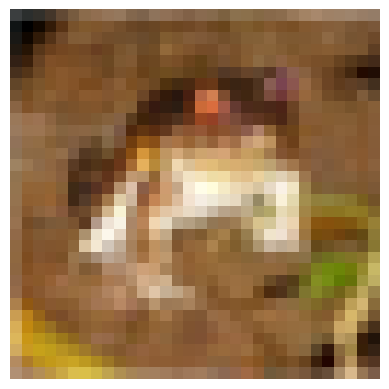

In [22]:
ind = 0
plt.imshow(np.transpose(X_train[ind], (1, 2, 0))) # Transpose the image to (height, width, channels)
plt.axis("off")
plt.show()

### Questions

<ol type = "A">
  <li> Complete the step member function of the GD class outlined below. This function should iterate through layers of the the model which have parameters and do a single step of gradient descent on both the weights and biases.  </li>
  <li> Complete the train function outlined below as per the comments.</li>
  <li> Try to create and train an instance of CNN_simple to fit CIFAR10. Experiment with changing the architecture of CNN_simple and also with doing some data preprocessing, e.g., normalisation. Comment on how your model performs and also on your observations with regard to the computational efficiency of your model versus the Pytorch implementation from Part I.</li>
</ol>

### A. implemeting a class for gradient descent (GD)

In [23]:
class GD:
  """
  Class implementing gradient descent for a neural network.
  """
  def __init__(self, model, lr):
    self.model = model
    self.lr = lr

  def step(self):
    # A.
    """
    Performs a single step of gradient descent for all parameters of the model.
    This function should iterate through layers of the the model which have parameters
    and do a single step of gradient descent on both the weights and biases.

    Inputs:
    -----------
    None

    Returns:
    ----------
    None
    """
    for layer in self.model.param_layers:
        # Check weight and bias
        if hasattr(layer, 'filters') and hasattr(layer, 'd_filters') and hasattr(layer, 'bias') and hasattr(layer, 'd_bias'):
            layer.w -= self.lr * layer.d_filters
            layer.b -= self.lr * layer.d_bias

        if hasattr(layer, 'w') and hasattr(layer, 'dw') and hasattr(layer, 'b') and hasattr(layer, 'db'):
            layer.w -= self.lr * layer.dw
            layer.b -= self.lr * layer.db

### B. Implementing a train function

In [24]:
def train(optimizer, x, y, x_tst, y_tst, N, max_epochs, thresh, log_rate):
  # B.
  """
  Trains a model using a minibatch updates applied through an optimizer class object.

  Inputs:
  -----------

  optimizer : an instance of optimizer class (e.g. an instance of the GD class). This class should have
  an lr (learning rate) and a model member variable, as well as a step() member function.

  x : a numpy array holding the input features of the training data

  y : a numpy array holding the labels of the training data

  x_tst : a numpy array holding the input features of the test data

  y_tst : a numpy array holding the labels of the test data

  N : scalar (int), the minibatch size to use during training

  max_epochs : scalar (int), the largest number of epochs to iterate over before terminating the function

  thresh : scalar (float), loss threshold which if reached should terminate the runtime of the function

  log_rate : scalar (int), the frequency with which to log the train and test loss during training (steps)


  Returns:
  ----------

  log_epoch : a python list containing the epochs when training and test errors where logged

  log_train : a python list containing the logged training errors

  log_test : a python list containing the logged test errors


  """
  # Extract shape information from arrays
  M = x.shape[0] # Number of points in the training data array
  M_test = x_tst.shape[0] # Number of points in the test data array
  n_batches = int(np.ceil(M/N)) # Number of batches per epoch
  log_epoch = []
  log_train = []
  log_test = []
  i = 0 # counter for the number of iters / epochs
  loss = 2*thresh # loss variable initialized so enter first while loop

  # EXAMPLE CODE SKETCH:
  # While loop until either threshold or max-iters / epochs is reached
    # Draw a random permutation over [M] where M is # training examples
    # For loop over over the number of batches
      # Extract next batch
      # Calculate predictions using model
      # Compute the loss
      # Run backward pass through the model to compute gradients of parameters
      # Update parameters using GD.step()
      # if is the first batch in an iter / epoch that is supposed to be logged then log the current train and test loss (you will need to comptute test loss on a test batch)
    # Increment the counter for the number of epochs / iters
    # CODE HERE

  while i < max_epochs and loss > thresh:

      perm = np.random.permutation(M)
      x_shuf, y_shuf = x[perm], y[perm]

      for b in range(n_batches):
          start = b * N
          end = min(start + N, M)
          x_batch, y_batch = x_shuf[start:end], y_shuf[start:end]

          y_pred = optimizer.model.forward(x_batch)
          loss = optimizer.model.loss(y_batch, y_pred)

          optimizer.model.backward(y_batch)
          optimizer.step()

          step_idx = i * n_batches + b

          if step_idx % log_rate == 0:
              train_loss = loss
              tst_size = min(N, M_test)
              tst_idx = np.random.choice(M_test, size=tst_size, replace = False)
              x_tst_mini, y_tst_mini = x_tst[tst_idx], y_tst[tst_idx]

              y_tst_pred = optimizer.model.forward(x_tst_mini)
              test_loss = optimizer.model.loss(y_tst_mini, y_tst_pred)
              log_epoch.append(step_idx)
              log_train.append(train_loss)
              log_test.append(test_loss)

              print(f"[Epoch {i+1}/{max_epochs} | Batch {b+1}/{n_batches}]",
                      f"train_loss={loss:.4f}", f"test_loss={test_loss:.4f}")

      i += 1

  return log_epoch, log_train, log_test




### C. Training an instance of CNN_simple to fit CIFAR10

In [25]:
# Set hyperparameters,
learning_rate = 0.02
batch_size = 512
max_epochs = 5
loss_thresh = 0.1
log_rate = 1


# normalisation of data
mean = X_train.mean(axis=(0,2,3), keepdims=True)
std  = X_train.std(axis=(0,2,3), keepdims=True)
X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std

# Create a small instance of CIFAR10
X_train, y_train = X_train[:1500], y_train[:1500]
X_test,  y_test  = X_test[:300],  y_test[:300]

# Initialize model and optimizer
model = CNN_simple()
model.layers = model.param_layers
optimizer = GD(model, lr=learning_rate)

In [26]:
# Call train function
log_epoch, log_train, log_test = train(
    optimizer,
    X_train, y_train,
    X_test, y_test,
    N = batch_size,
    max_epochs = max_epochs,
    thresh = loss_thresh,
    log_rate = log_rate
)

KeyboardInterrupt: 

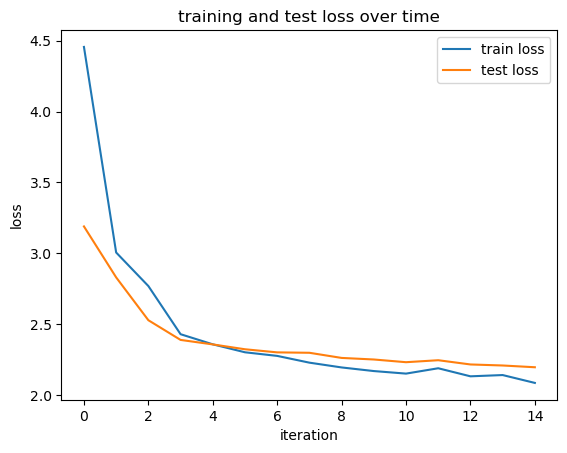

In [ ]:
# Plot the training and test error
plt.figure()
plt.plot(log_epoch, log_train, label='train loss')
plt.plot(log_epoch, log_test, label='test loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and test loss over time')
plt.legend()
plt.show()


Our Neural Network that we have made using python ends up with a train and test loss of around 2.2 and 2.3 respectively. Compared to our PyTorch model this is considerably worse as we were unable to introduce the number of layers and complexity within our model as we did using PyTorch due to the slow computation time it took within python. With each epoch taking around 2-3 minutes to run compared to pytorchs 20-30 second epochs with a more complex Neural Network. The advantage about PyTorch is that it uses a hybrid stucture, using C++ for all the heavy computations such as convolutions and automatic differentiation and python to allow the writing of the training loops and model definitions. Since C++ computes a lot faster than Python this is the main reason as to why our Neural Network is considerably slower than the PyTorch model in question 1. That being said, our model is robustly running off all of our previously defined classes producing a correct Neural Network for the CIFAR-10 data.